In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import xgboost.dask
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn import metrics

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, SSHCluster
import dask.distributed

from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import LabelEncoder

# import dask_xgboost
# import dask_ml.xgboost # outdated, better not to use

# import hvplot.dask

In [2]:
xgboost.dask.train

<function xgboost.dask.train(client: 'distributed.Client', params: Dict[str, Any], dtrain: xgboost.dask.DaskDMatrix, num_boost_round: int = 10, *, evals: Optional[Sequence[Tuple[xgboost.dask.DaskDMatrix, str]]] = None, obj: Optional[Callable[[numpy.ndarray, xgboost.core.DMatrix], Tuple[numpy.ndarray, numpy.ndarray]]] = None, feval: Optional[Callable[[numpy.ndarray, xgboost.core.DMatrix], Tuple[str, float]]] = None, early_stopping_rounds: Optional[int] = None, xgb_model: Optional[xgboost.core.Booster] = None, verbose_eval: Union[int, bool] = True, callbacks: Optional[Sequence[xgboost.callback.TrainingCallback]] = None, custom_metric: Optional[Callable[[numpy.ndarray, xgboost.core.DMatrix], Tuple[str, float]]] = None) -> Any>

In [3]:
dir(xgboost.dask)

['Any',
 'Awaitable',
 'Booster',
 'Callable',
 'CommunicatorContext',
 'DMatrix',
 'DaskDMatrix',
 'DaskDeviceQuantileDMatrix',
 'DaskPartitionIter',
 'DaskQuantileDMatrix',
 'DaskScikitLearnBase',
 'DaskXGBClassifier',
 'DaskXGBRFClassifier',
 'DaskXGBRFRegressor',
 'DaskXGBRanker',
 'DaskXGBRegressor',
 'DataFrame',
 'DataIter',
 'Dict',
 'FeatureNames',
 'FeatureTypes',
 'Generator',
 'LOGGER',
 'LazyLoader',
 'List',
 'Metric',
 'Objective',
 'Optional',
 'QuantileDMatrix',
 'RabitTracker',
 'Sequence',
 'Set',
 'TYPE_CHECKING',
 'Thread',
 'TrainReturnT',
 'TrainingCallback',
 'Tuple',
 'TypeVar',
 'TypedDict',
 'Union',
 'XGBClassifier',
 'XGBClassifierBase',
 'XGBModel',
 'XGBRanker',
 'XGBRankerMixIn',
 'XGBRegressorBase',
 '_DaskCollection',
 '_DataParts',
 '_DataT',
 '_MapRetT',
 '_T',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_assert_dask_support',
 '_async_wrap_evaluation_matrices',
 '_ca

In [4]:
# cluster.close()

In [5]:
# if __name__ == "__main__":
    # cluster = dask.distributed.LocalCluster()
    # client = dask.distributed.Client(cluster)
cluster = SSHCluster(["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )

client=Client(cluster)

2023-06-24 20:36:23,458 - distributed.deploy.ssh - INFO - 2023-06-24 20:36:23,456 - distributed.scheduler - INFO - State start
2023-06-24 20:36:23,461 - distributed.deploy.ssh - INFO - 2023-06-24 20:36:23,458 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-nnpl1zqt', purging
2023-06-24 20:36:23,462 - distributed.deploy.ssh - INFO - 2023-06-24 20:36:23,459 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7u4tfmy5', purging
2023-06-24 20:36:23,463 - distributed.deploy.ssh - INFO - 2023-06-24 20:36:23,459 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-i2_xm071', purging
2023-06-24 20:36:23,465 - distributed.deploy.ssh - INFO - 2023-06-24 20:36:23,460 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7ne5oeng', purging
2023-06-24 20:36:23,467 - distributed.deploy.ssh - INFO - 2023-06

In [6]:
# cluster

In [7]:
q_drop = 0.2
#import data
bhbh = dd.read_parquet('/home/ubuntu/data/bag_all_dataset_with_no_kick/*')
bhbh = bhbh[bhbh['q']>q_drop]

In [8]:
# bhbh.compute()

In [9]:
#add column label
# n_bins = int(np.sqrt(len(bhbh)))
n_bins=50

# Define the edges between bins
counts, bin_edges = da.histogram(bhbh.q.values, bins=n_bins, range=(q_drop,1.0))

# pd.cut each column, with each bin closed on left and open on right
bhbh['label'] = bhbh['q'].map_partitions(pd.cut, bin_edges, right=True, labels=False, include_lowest=False)

print('bin_edges:', len(bin_edges))
print(counts)

bin_edges: 51
dask.array<sum-aggregate, shape=(50,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>


In [10]:
# np.unique(bhbh['label'].compute())

In [11]:
bin_edges

array([0.2  , 0.216, 0.232, 0.248, 0.264, 0.28 , 0.296, 0.312, 0.328,
       0.344, 0.36 , 0.376, 0.392, 0.408, 0.424, 0.44 , 0.456, 0.472,
       0.488, 0.504, 0.52 , 0.536, 0.552, 0.568, 0.584, 0.6  , 0.616,
       0.632, 0.648, 0.664, 0.68 , 0.696, 0.712, 0.728, 0.744, 0.76 ,
       0.776, 0.792, 0.808, 0.824, 0.84 , 0.856, 0.872, 0.888, 0.904,
       0.92 , 0.936, 0.952, 0.968, 0.984, 1.   ])

In [12]:
# counts.compute()

In [13]:
# bhbh.compute()

In [14]:
bhbh_partitions = bhbh.npartitions

In [15]:
# bhbh = bhbh.persist()

In [16]:
# #Data
# X = bhbh[['Mass_0', 'Z_0', 'Mass_1', 'a', 'e']]
# y = bhbh['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [17]:
bhbh_train, bhbh_test=train_test_split(bhbh, train_size=0.8, shuffle=True)

In [18]:
len(bhbh_train) # check number of records

5991527

In [19]:
bhbh_train=bhbh_train.repartition(120)

In [20]:
len(bhbh_train) # check consistency after repartitioning

5991527

In [21]:
bhbh_train=bhbh_train.reset_index(drop=True)

In [22]:
countings=bhbh['label'].to_frame().groupby('label').size().compute()

In [23]:
total_counts=countings.sum()

In [24]:
n_bins

50

In [25]:
def assign_weight(i):
    return total_counts/(n_bins*countings[i])

In [26]:
bhbh_train['weight']=bhbh_train['label'].map(assign_weight)

In [27]:
labs_weights=bhbh_train[['label', 'weight']].compute()

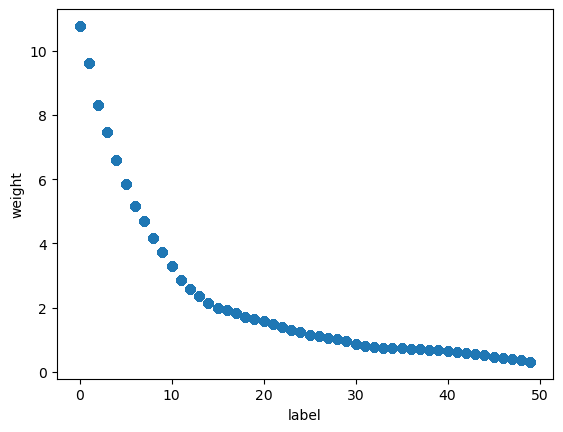

In [28]:
# plt.scatter(x=labs_weights.label, y=labs_weights.weight)
# plt.xlabel('label')
# plt.ylabel('weight')
# plt.savefig('labels_vs_weight.png')

In [29]:
bhbh_train.columns

Index(['name', 'Mass_0', 'Z_0', 'SN_0', 'Mass_1', 'SN_1', 'a', 'e', 'alpha',
       'Mass_0_out', 'Mass_1_out', 'Semimajor', 'Eccentricity', 'GWtime',
       'BWorldtime', 'RLO', 'CE', 'BSN', 'No_Kick', 'tdelay', 'Mass_max_out',
       'q', 'Mass_chirp', 'label', 'weight'],
      dtype='object')

In [30]:
weights=bhbh_train['weight']
labels=bhbh_train['label']
features=bhbh_train[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]

In [31]:
type(features), features.npartitions

(dask.dataframe.core.DataFrame, 120)

In [32]:
type(labels), labels.npartitions

(dask.dataframe.core.Series, 120)

In [33]:
#weights
# le = LabelEncoder()
# y_train = dask.dataframe.from_array(le.fit_transform(y_train))
# sample_weight  = custom_weight[y_train]
# sample_weights = dask.dataframe.from_pandas(pd.DataFrame({'weight':sample_weight}), npartitions=1800)
# sample_weights = sample_weights.repartition(240).to_dask_array(lengths=True)

In [63]:
#parameters
n_estimators = 10
max_depth = 8
learning_rate = 0.3
grow_policy = 'lossguide'
max_leaves = 10

param = {'objective': 'multi:softprob',
        'grow_policy' : 'depthwise', 
        # 'n_estimators' : n_estimators, 
        'max_depth' : max_depth,
        'learning_rate' : learning_rate,
        'max_leaves' : n_bins,
        'num_class': n_bins,
        # 'n_jobs' : -1
        }

In [64]:
dtrain = xgb.dask.DaskDMatrix(client, features, label=labels, weight=weights)

In [65]:
dtrain

In [66]:
bst = xgb.dask.train(client, param, dtrain, num_boost_round=2, evals=[(dtrain, "train")])

In [67]:
bst=bst['booster']

In [68]:
output=xgb.dask.predict(client,bst,dtrain)

In [69]:
dist_1=output.to_dask_dataframe().head()

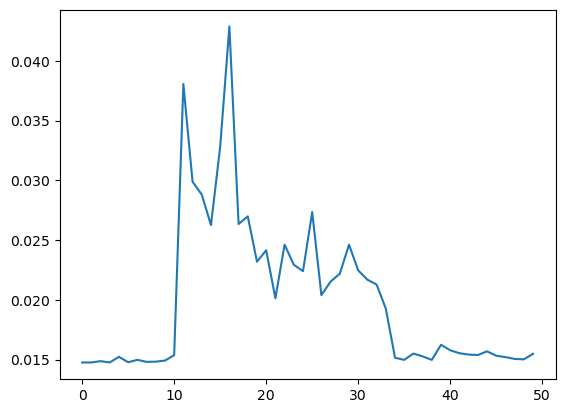

In [73]:
plt.plot(dist_1.iloc[2])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [ ]:
y_train_predict = model.predict(X_train)
#prediction = le.inverse_transform(prediction)

In [ ]:
y_train_predict.shape, X_train.shape

In [ ]:
plt.hist(y_train_predict, bins=n_bins, alpha=1, label='predict')
plt.hist(y_train, alpha=0.5, bins=n_bins, label='labels')
plt.legend()

In [ ]:
prob_y_train_pred = model.predict_proba(X_train)
prob_y_train_pred.shape

k = 5
plt.plot(range(0,n_bins), prob_y_train_pred[k])
print(y[k], y_train_predict[k])

In [ ]:
y_test_pred = model.predict(X_test)
#y_pred = le.inverse_transform(y_pred)
cm = confusion_matrix(y_test, y_test_pred)
# print(cm)

# print(accuracy_score(y_test, y_test_pred, normalize=True))
# print(accuracy_score(y_train, y_train_predict))

In [ ]:
prob_y_test_pred = model.predict_proba(X_test)
plt.plot(range(0, n_bins), prob_y_test_pred[2])

In [ ]:
label_values = np.arange(0, n_bins)

In [ ]:
y_test_label_predict_max = np.argmax(prob_y_test_pred, axis=1)
plt.scatter(y_test, y_test_label_predict_max, s=0.1)
plt.plot(y_test, y_test, color='red')
plt.xlabel('y_tes')
plt.ylabel('y_test_label_predict_max')

In [ ]:
y_test_label_predict_mean = np.sum(prob_y_test_pred*(label_values), axis=1)
y_test_label_predict_variance = np.sum(prob_y_test_pred * (label_values.reshape(1,n_bins) - y_test_label_predict_mean.reshape(len(y_test_label_predict_mean), 1))**2, axis=1)
y_test_label_predict_std = np.sqrt(y_test_label_predict_variance)

plt.errorbar(y_test[:100], y_test_label_predict_mean[:100], yerr=y_test_label_predict_std[:100], fmt='.')
plt.plot(y_test[:100], y_test[:100], color='red')
# plt.errorbar(y_test, y_test_label_predict_mean, yerr=y_test_label_predict_std, fmt='.')
# plt.plot(y_test, y_test, color='red')
plt.xlabel('y_tes')
plt.ylabel('y_test_label_predict_mean')

In [ ]:
plt.scatter(y_test, y_test_label_predict_mean, s=0.1)
plt.plot(y_test, y_test, color='red')
plt.xlabel('y_tes')
plt.ylabel('y_test_label_predict_mean')

In [ ]:
chi = np.sum(((y_test_label_predict_mean - y_test)**2)/y_test_label_predict_variance)
chi_norm = chi/len(y_test)
print(chi)
print(chi_norm)

In [ ]:
import seaborn as sns

In [ ]:
sns.scatterplot(x=y_test, y=y_test_label_predict_max, hue = X_test['Z_1'], s=1)

In [ ]:
X_test